<a href="https://colab.research.google.com/github/San-lab-ship/modelo-riesgo-crediticio-impacto-financiero/blob/main/modelo_riesgo_crediticio_impacto_financiero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
sns.set(style="whitegrid")


In [2]:
# Dataset sintético
n = 5000

df = pd.DataFrame({
    "ingresos": np.random.normal(3000, 800, n),
    "ratio_deuda_ingreso": np.random.beta(2,5,n),
    "utilizacion_credito": np.random.beta(2,4,n),
    "antiguedad_cliente": np.random.randint(1,10,n),
    "segmento": np.random.choice(["Bajo Riesgo","Medio Riesgo","Alto Riesgo"], n)
})

# Probabilidad base
df["default"] = (
    0.3*df["ratio_deuda_ingreso"] +
    0.4*df["utilizacion_credito"] -
    0.00005*df["ingresos"] +
    np.random.normal(0,0.05,n)
)

df["default"] = (df["default"] > df["default"].median()).astype(int)


In [3]:
X = df[["ingresos","ratio_deuda_ingreso","utilizacion_credito","antiguedad_cliente"]]
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

model = RandomForestClassifier()
model.fit(X_train,y_train)

y_probs = model.predict_proba(X_test)[:,1]


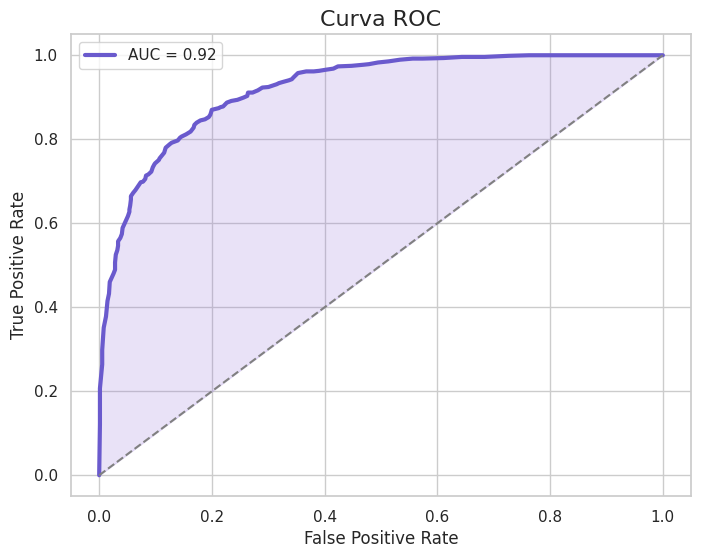

KS: 0.67


In [4]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
ks = max(tpr - fpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="#6A5ACD", linewidth=3, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.fill_between(fpr, tpr, fpr, alpha=0.2, color="#9370DB")
plt.title("Curva ROC", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("KS:", round(ks,3))


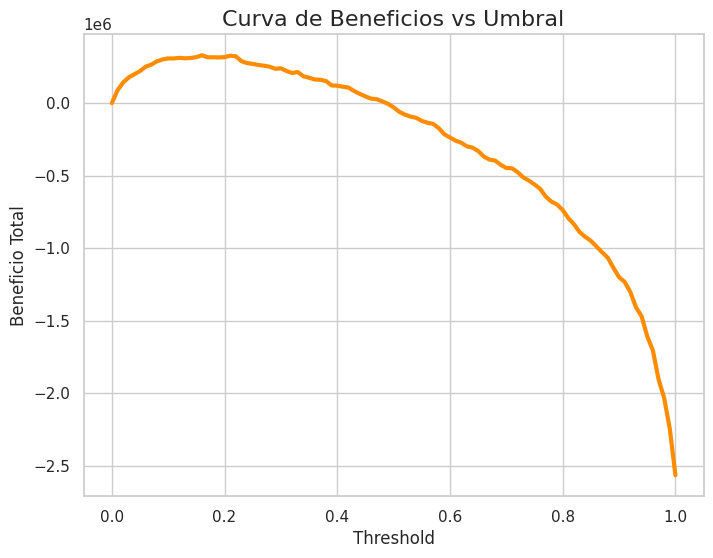

In [5]:
interest = 1000
loss = 5000

profits = []

for t in thresholds:
    decisions = (y_probs < t).astype(int)
    profit = np.sum(
        (1 - y_test) * decisions * interest -
        y_test * decisions * loss
    )
    profits.append(profit)

plt.figure(figsize=(8,6))
plt.plot(thresholds, profits, color="#FF8C00", linewidth=3)
plt.title("Curva de Beneficios vs Umbral", fontsize=16)
plt.xlabel("Threshold")
plt.ylabel("Beneficio Total")
plt.show()


/tmp/ipython-input-1388568053.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x="segmento", y="prob_default", palette="Set2")


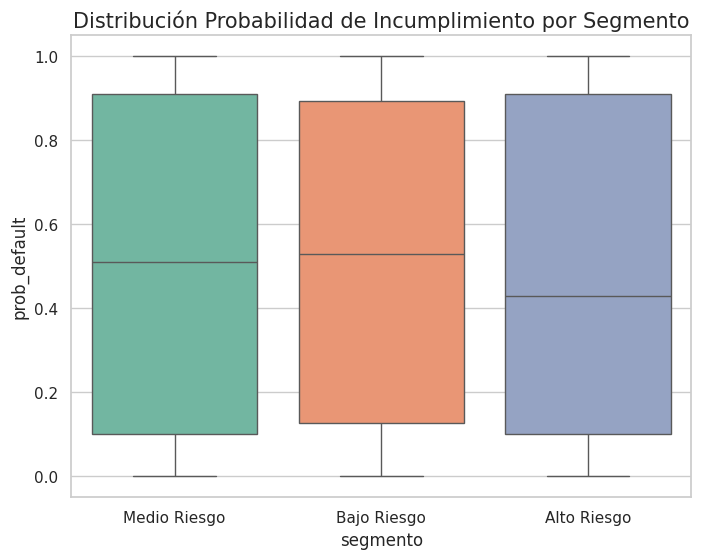

In [6]:
df_test = X_test.copy()
df_test["prob_default"] = y_probs
df_test["segmento"] = df.loc[X_test.index,"segmento"]

plt.figure(figsize=(8,6))
sns.boxplot(data=df_test, x="segmento", y="prob_default", palette="Set2")
plt.title("Distribución Probabilidad de Incumplimiento por Segmento", fontsize=15)
plt.show()


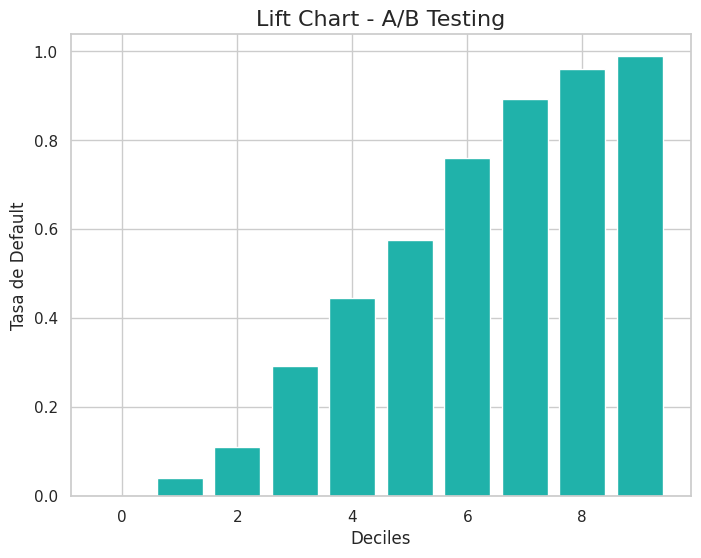

In [7]:
df_lift = pd.DataFrame({"y": y_test, "prob": y_probs})
df_lift = df_lift.sort_values("prob", ascending=False)
df_lift["decile"] = pd.qcut(df_lift["prob"], 10, labels=False)

lift = df_lift.groupby("decile")["y"].mean()

plt.figure(figsize=(8,6))
plt.bar(range(10), lift, color="#20B2AA")
plt.title("Lift Chart - A/B Testing", fontsize=16)
plt.xlabel("Deciles")
plt.ylabel("Tasa de Default")
plt.show()


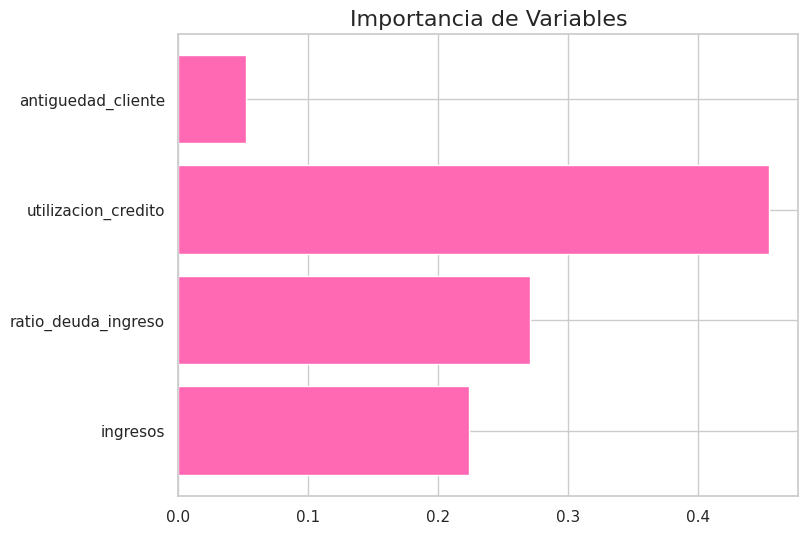

In [8]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,6))
plt.barh(features, importances, color="#FF69B4")
plt.title("Importancia de Variables", fontsize=16)
plt.show()


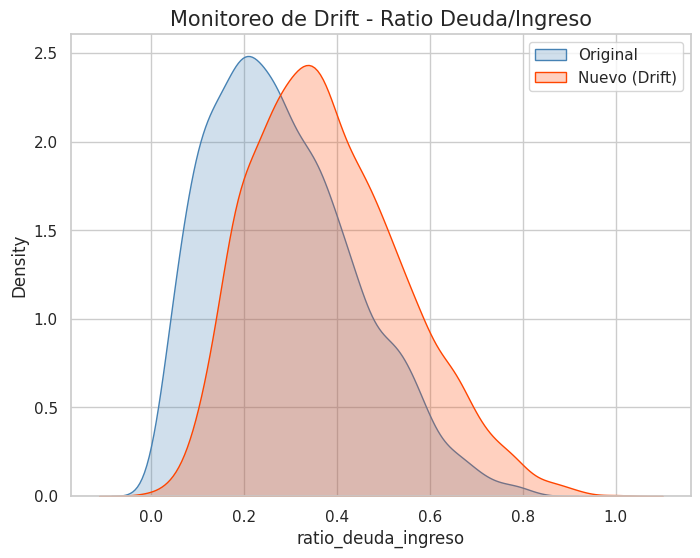

In [9]:
# Simulamos drift
df_new = df.copy()
df_new["ratio_deuda_ingreso"] += np.random.normal(0.1,0.05,n)

plt.figure(figsize=(8,6))
sns.kdeplot(df["ratio_deuda_ingreso"], label="Original", color="#4682B4", fill=True)
sns.kdeplot(df_new["ratio_deuda_ingreso"], label="Nuevo (Drift)", color="#FF4500", fill=True)
plt.title("Monitoreo de Drift - Ratio Deuda/Ingreso", fontsize=15)
plt.legend()
plt.show()
